In [13]:
import gym
import gym_futbol
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
import utils
from multiagent import MultiAgentModelProxy

# Basics

In [ ]:
env = gym.make("Futbol2v2-v1")
env.render()

In [ ]:
env.action_space

In [ ]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

# Learning model

In [12]:
log_dir = "logs/"
timesteps = 100000

In [ ]:
from stable_baselines3.common.env_util import make_vec_env

env = gym.make("Futbol2v2-v1")
env = make_vec_env(lambda: env, n_envs=4, monitor_dir=log_dir)
model = A2C("MlpPolicy", env, device='cpu')
model.learn(timesteps, progress_bar=True)
model.save("models/footbol2v2-a2c")

# Display model statistic

     index            r   l           t
0        0   172.634473  75    0.556703
1        1   124.632164  75    0.893679
2        2    90.968688  75    1.256261
3        3    76.612176  75    1.623350
4        4   245.413219  75    1.960592
..     ...          ...  ..         ...
328    328   269.095398  75  131.631002
329    329   442.319189  75  132.039856
330    330  1606.574365  75  132.445689
331    331   533.459551  75  132.838477
332    332  -895.702063  75  133.231494

[333 rows x 4 columns]


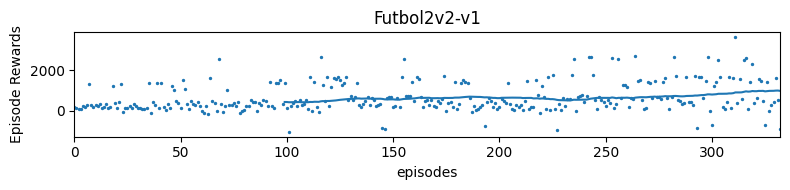

In [16]:
from IPython import display
from stable_baselines3.common import results_plotter

results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

log_data = results_plotter.load_results(log_dir)
print(log_data)

# Load model from file

In [ ]:
model = A2C.load("models/footbol2v2-a2c", device="cpu")

# Run models

## Pygame
Run game with model in new windows with pygame

In [ ]:
RES = WIDTH, HEIGHT = 600, 600
FPS = 60

env = gym.make("Futbol2v2-v1", width=WIDTH-2, height=HEIGHT-2, player_radius=15, ball_radius=5)
visualizer = utils.PygameVisualizer(env, FPS)
visualizer.run(model)

env.close()
visualizer.close()

## Matplotlib
Run model in notebook with matplotlib

In [ ]:
env = gym.make("Futbol2v2-v1")

visualizer = utils.MatplotlibVisualizer(env)
visualizer.run(model)

env.close()

# MultiAgent

## Learn

In [14]:
env = make_vec_env(lambda: gym.make("Futbol2v2-v1"), n_envs=1)

models = [
    MultiAgentModelProxy(A2C("MlpPolicy",
                             utils.TransformAction(env, lambda a: a[:2], gym.spaces.MultiDiscrete([5, 5])),
                             device='cpu')),
    MultiAgentModelProxy(A2C("MlpPolicy",
                             utils.TransformAction(env, lambda a: a[2:4], gym.spaces.MultiDiscrete([5, 5])),
                             device='cpu'))
]

static_models = [
    utils.RandomStaticAgent(utils.TransformAction(env, lambda a: a[2:4], gym.spaces.MultiDiscrete([5, 5]))),
    utils.RandomStaticAgent(utils.TransformAction(env, lambda a: a[2:4], gym.spaces.MultiDiscrete([5, 5])))
]

timesteps = 1000
n_records_count = models[0].model.n_steps
max_episode_reward = 0

### Rewrote learning cycle
StableBaselines3 не поддерживает одновременное обучение нескольких агентов, это даже не ошибка по мнению разработчиков. Они считают, что в данном случае каждому пользователю необходимо самостоятельо переопределить цикл обучения (для не мультиагентных задач используется метод learn). Здесь представлен код, взятый из исходных кодов StableBaselines3, но адаптированный для многоагентных задач.
В обычной ситуации, learn сам взаимодействует со средой. Но при существовании нескольких агентов нужно получить действие от каждого и только потом передавать их в среду. Именно это здесь и реализовано. Каждому агенту передается наблюдение от среды (в данной задаче оно одинаково для всех) и получается действие. Затем действия объеядиняются и передаются среде. Затем каждый агент обновляется с учетом полученных данных (метод record).
Весь код, взятый из StableBaselines3 вынесен в класс MultiAgentModelProxy.

In [15]:
#TODO: рассмотреть возможность асинхронной среды
#TODO: добавить вывод логов для последующего использования results_plotter

In [16]:
for model in models:
    model.start_learning(timesteps)

for time in range(timesteps):
    done = False
    episode_reward = 0
    observation = env.reset()

    while not done:
        actions = [np.reshape(model.predict(observation)[0], (-1, 2)) for model in models+static_models]
        total_action = np.concatenate(np.concatenate(actions))

        for model in models:
            model.start_record()

        for step in range(n_records_count):
            next_observation, reward, done, info = env.step(np.array([total_action]))
            episode_reward += reward

            for model, action in zip(models, actions):
                model.record(observation, action, next_observation, reward, done, info)

        for model in models:
            model.end_record()
            model.train()

    if episode_reward > max_episode_reward:
        max_episode_reward = episode_reward
        for index, model in enumerate(models):
            model.model.save(f"models/footbol2v2-a2c-{index}")
    print(time, episode_reward)

0 [-1091.6887]
1 [822.0816]
2 [1774.9917]
3 [445.4238]
4 [827.3867]
5 [2287.516]
6 [978.4781]
7 [449.45312]
8 [276.0921]
9 [-1067.554]
10 [702.4676]
11 [1575.2356]
12 [844.7919]
13 [998.80963]
14 [1386.2634]
15 [763.14264]
16 [466.1182]
17 [1098.9585]
18 [577.1648]
19 [360.13446]
20 [1633.5005]
21 [991.8707]
22 [1475.1755]
23 [2296.2898]
24 [569.91296]
25 [3236.7478]
26 [431.69922]
27 [648.0191]
28 [2347.062]
29 [1974.8229]
30 [1187.0518]
31 [777.9736]
32 [-1007.61334]
33 [-940.43933]
34 [652.0781]
35 [1184.5431]
36 [1177.8997]
37 [3619.2551]
38 [-327.47617]
39 [2063.9478]
40 [679.4136]
41 [988.8791]
42 [343.8934]
43 [2165.151]
44 [-333.58826]
45 [2038.9252]
46 [622.4943]
47 [3235.1528]
48 [2264.316]
49 [1779.6807]
50 [606.46423]
51 [-773.4988]
52 [278.784]
53 [608.8482]
54 [2868.6228]
55 [1674.0176]
56 [539.0059]
57 [697.24756]
58 [850.95966]
59 [339.88864]
60 [708.8264]
61 [675.49554]
62 [-1270.5271]
63 [127.28037]
64 [254.30202]
65 [-414.12717]
66 [1112.613]
67 [785.039]
68 [521.563

KeyboardInterrupt: 

## Load and visualise

In [17]:
models = [A2C.load(f"models/footbol2v2-a2c-{index}", device="cpu") for index in range(2)]

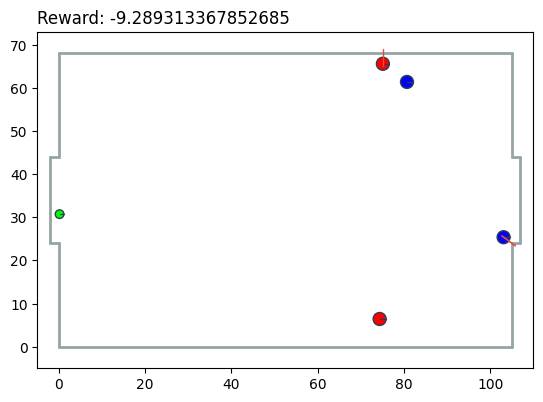

In [18]:
env = gym.make("Futbol2v2-v1")

static_models = [
    utils.RandomStaticAgent(utils.TransformAction(env, lambda a: a[2:4], gym.spaces.MultiDiscrete([5, 5]))),
    utils.RandomStaticAgent(utils.TransformAction(env, lambda a: a[2:4], gym.spaces.MultiDiscrete([5, 5])))
]
multi_agent = utils.MultiModelAgent(models+static_models)

visualizer = utils.MatplotlibVisualizer(env)
visualizer.run(multi_agent)

env.close()